In [1]:
import tqdm
import pickle
import numpy as np
import tensorflow as tf
import scipy
import sklearn
import sklearn.datasets
import sklearn.covariance
import sklearn.preprocessing
import pandas as pd
import plotly
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('ticks')
# seaborn.set(style='ticks', font='TakaoGothic')
matplotlib.rcParams['pdf.fonttype'] = 42
plotly.offline.init_notebook_mode(connected=True)
palette = sns.color_palette("RdBu_r", n_colors=25)
% matplotlib inline

import knn

/home/ytakashina/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = sklearn.datasets.load_iris()
features = sklearn.preprocessing.scale(data.data)
target = data.target

In [3]:
d_c = 4
k = 3
n = 150
lamb = 0.3 * n
np.random.seed(1)

In [4]:
alpha = tf.Variable(np.zeros(d_c), dtype=tf.float32)
beta_ = tf.Variable(np.random.gamma(1, size=[d_c, d_c]), dtype=tf.float32)
beta_triu = tf.matrix_band_part(beta_, 0, -1)
beta_diag = tf.matrix_band_part(beta_, 0, 0)
beta = beta_triu + tf.transpose(beta_triu) - beta_diag
rho = tf.Variable(np.random.normal(size=[d_c, k]), dtype=tf.float32)
phi = tf.Variable(np.random.normal(size=[k]), dtype=tf.float32)

In [5]:
x = tf.placeholder(tf.float32, [n, d_c])
y = tf.placeholder(tf.int32, [n])

In [6]:
beta_diag = tf.diag_part(beta)                    # [d_c]
rho_y = tf.gather(rho, y, axis=1)                 # [d_c, n]
beta_x = tf.matmul(beta, tf.transpose(x))         # [d_c, n]
dev = tf.reshape(alpha, [-1, 1]) + rho_y - beta_x # [d_c, n]
loss = -0.5 * n * tf.reduce_sum(tf.log(beta_diag))
loss += tf.reduce_sum(dev * dev / tf.reshape(beta_diag, [-1, 1]) / 2)

In [7]:
rho_x = tf.matmul(x, rho)                 # [n, k]
logits = rho_x + tf.reshape(phi, [1, -1]) # [n, k]
p_k = tf.nn.softmax(logits)               # [n, k]
y_onehot = tf.one_hot(y, k)               # [n, k]
loss += -tf.reduce_sum(tf.log(tf.reduce_sum(p_k * y_onehot, axis=1)))

In [8]:
# regularizer
# beta_nondiag = beta - tf.matrix_band_part(beta, 0, 0)
# loss += 0.5 * lamb * (tf.reduce_sum(tf.abs(beta_nondiag)))
# loss += np.sqrt(2/3) * lamb * tf.reduce_sum(tf.norm(rho, axis=1))
regularizer = tf.contrib.layers.l1_regularizer(scale=lamb)
weights_list = [beta_triu - beta_diag, np.sqrt(2/3) * tf.norm(rho, axis=1)]
loss += tf.contrib.layers.apply_regularization(regularizer, weights_list)

In [9]:
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
summary_op = tf.summary.scalar("loss", loss)
summary_writer = tf.summary.FileWriter('loss', graph=tf.get_default_graph())
display_epoch = 10000
training_epochs = 100000

In [12]:
for epoch in range(training_epochs):
    _, l, summary = sess.run([optimizer, loss, summary_op], {x: features, y: target})
    summary_writer.add_summary(summary, epoch)

    if (epoch+1) % display_epoch == 0:
        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(l))

    if np.isnan(l):
        print('loss becomes nan at epoch %d' % epoch)
        break

Epoch: 10000 loss= 660.039794922
Epoch: 20000 loss= 660.039794922
Epoch: 30000 loss= 660.039794922
Epoch: 40000 loss= 660.039794922
Epoch: 50000 loss= 660.039794922
Epoch: 60000 loss= 660.039794922
Epoch: 70000 loss= 660.039794922
Epoch: 80000 loss= 660.039794922
Epoch: 90000 loss= 660.039794922
Epoch: 100000 loss= 660.039794922


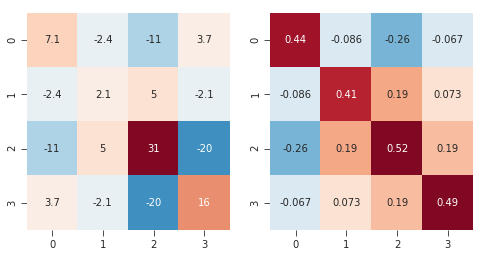

In [13]:
pre_sample = np.linalg.inv(np.cov(features, rowvar=0))
pre_estimate = sess.run(beta)
f, axes = plt.subplots(1, 2, figsize=[8, 4])
sns.heatmap(pre_sample, ax=axes[0], cmap=palette, cbar=False, annot=True, center=0)
sns.heatmap(pre_estimate, ax=axes[1], cmap=palette, cbar=False, annot=True, center=0)

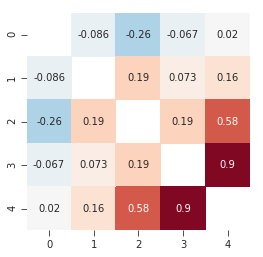

In [14]:
rho_estimate = sess.run(rho)
adj_cc = pre_estimate
adj_dc = np.linalg.norm(rho_estimate, axis=1)
adj_u = np.hstack((adj_cc, adj_dc.reshape(-1, 1)))
adj_l = np.append(adj_dc, np.nan)
adj = np.vstack((adj_u, adj_l))
adj[np.eye(5, dtype=bool)] = np.nan
plt.figure(figsize=[4, 4])
sns.heatmap(adj, cmap=palette, cbar=False, annot=True, center=0)

In [15]:
df = pd.DataFrame(features)
df['class'] = target

In [16]:
n, d = df.values.shape
edges = knn.learn_mrf(df.values)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj2 = nx.adjacency_matrix(g).toarray().astype(float)
adj2[np.eye(d, dtype=bool)] = np.nan

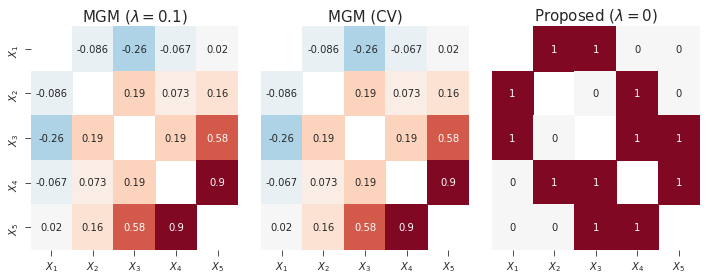

In [17]:
f, axes = plt.subplots(1, 3, figsize=[10, 4])
axes[0].set_title('MGM ($\lambda = 0.1$)', fontsize=15)
axes[1].set_title('MGM (CV)', fontsize=15)
axes[2].set_title('Proposed ($\lambda = 0$)', fontsize=15)
labels = ['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
sns.heatmap(adj, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False, xticklabels=labels, yticklabels=labels)
sns.heatmap(adj, annot=True, center=0, ax=axes[1], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
sns.heatmap(adj2, annot=True, center=0, ax=axes[2], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
plt.tight_layout()
plt.savefig('output/heat-iris.pdf', format='pdf')

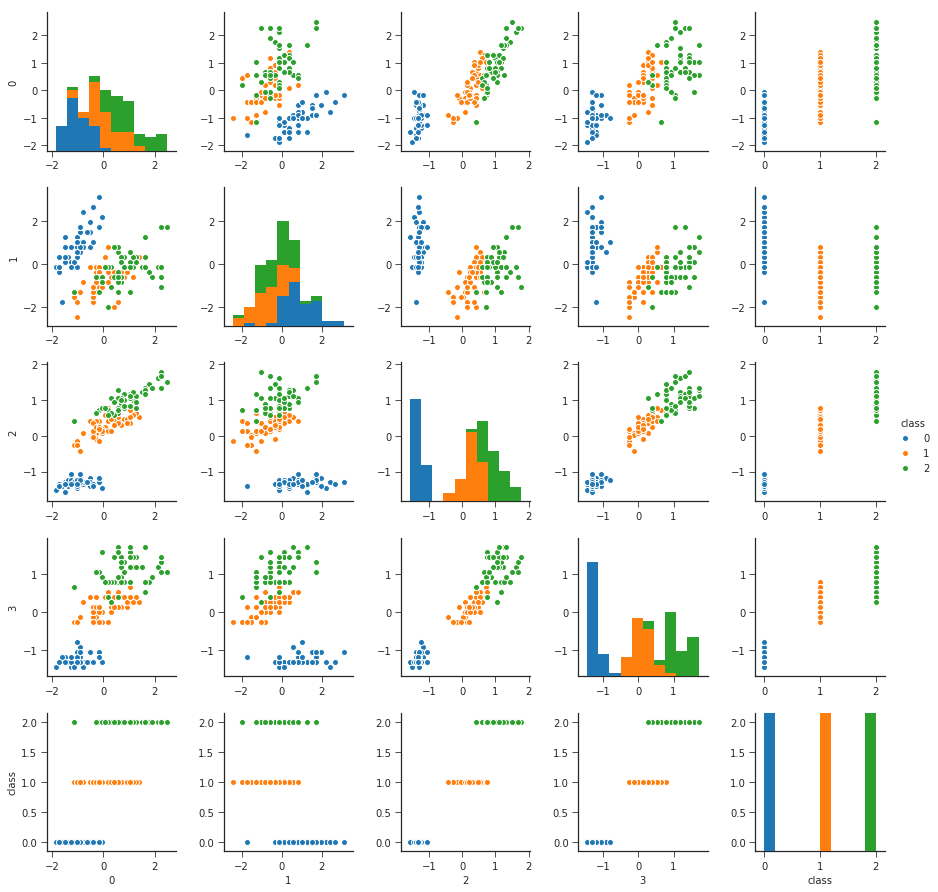

In [18]:
sns.pairplot(df, hue='class')